<a href="https://colab.research.google.com/github/ZackPashkin/swin-transformer-pytorch-starter/blob/main/resnet50_vs_swin_transformer_tiny_pytorch_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jul 20 13:19:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    41W / 300W |   1655MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb -qqq
import wandb
# Log in to your W&B account
wandb.login()

True

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 128
epochs = 20

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


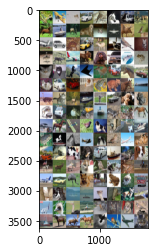

 frog plane  deer   car  bird horse truck  deer horse  ship  deer   dog  frog plane  deer  bird plane   car  frog   car  deer   cat  bird   cat  bird  deer plane horse   dog   car  ship  frog   cat   cat horse plane  deer   car horse   car   cat   car   car   dog  frog   cat horse  ship  bird   cat  deer  ship  bird   car   dog  frog truck truck  frog truck  ship   cat  deer horse  ship horse plane  bird   dog  bird   dog  ship  frog horse  deer plane   dog  bird plane   dog   car   dog   dog   dog   car  ship  frog   dog horse  deer truck   cat  bird  frog  frog horse plane   car  bird   cat  deer  frog   dog truck   cat   dog  ship  ship  bird  frog   dog plane plane  bird  bird plane  deer  deer   dog  bird  ship horse  deer horse  bird  bird plane   cat


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
import torchvision.models as models
net = models.resnet50(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 10)


dummy_x = torch.randn(1, 3, 224, 224)
logits = net(dummy_x)  
net = net.to(device)

In [ ]:
# model description
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

from collections import OrderedDict
import numpy as np

model = net
input_size = (3,224,224)
batch_size= 128
device="cuda"

def register_hook(module):

    def hook(module, input, output):
        class_name = str(module.__class__).split(".")[-1].split("'")[0]
        module_idx = len(summary)

        m_key = "%s-%i" % (class_name, module_idx + 1)
        summary[m_key] = OrderedDict()
        summary[m_key]["input_shape"] = list(input[0].size())
        summary[m_key]["input_shape"][0] = batch_size
        if isinstance(output, (list, tuple)):
            summary[m_key]["output_shape"] = [
                [-1] + list(o.size())[1:] for o in output
            ]
        else:
            summary[m_key]["output_shape"] = list(output.size())
            summary[m_key]["output_shape"][0] = batch_size

        params = 0
        if hasattr(module, "weight") and hasattr(module.weight, "size"):
            params += torch.prod(torch.LongTensor(list(module.weight.size())))
            summary[m_key]["trainable"] = module.weight.requires_grad
        if hasattr(module, "bias") and hasattr(module.bias, "size"):
            params += torch.prod(torch.LongTensor(list(module.bias.size())))
        summary[m_key]["nb_params"] = params

    if (
        not isinstance(module, nn.Sequential)
        and not isinstance(module, nn.ModuleList)
        and not (module == model)
    ):
        hooks.append(module.register_forward_hook(hook))

device = device.lower()
assert device in [
    "cuda",
    "cpu",
], "Input device is not valid, please specify 'cuda' or 'cpu'"

if device == "cuda" and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# multiple inputs to the network
if isinstance(input_size, tuple):
    input_size = [input_size]

# batch_size of 2 for batchnorm
x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
# print(type(x[0]))

# create properties
summary = OrderedDict()
hooks = []

# register hook
model.apply(register_hook)

# make a forward pass
# print(x.shape)
model(*x)

# remove these hooks
for h in hooks:
    h.remove()

print("----------------------------------------------------------------")
line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
print(line_new)
print("================================================================")
total_params = 0
total_output = 0
trainable_params = 0
for layer in summary:
    # input_shape, output_shape, trainable, nb_params
    line_new = "{:>20}  {:>25} {:>15}".format(
        layer,
        str(summary[layer]["output_shape"]),
        "{0:,}".format(summary[layer]["nb_params"]),
    )
    total_params += summary[layer]["nb_params"]
    total_output += np.prod(summary[layer]["output_shape"])
    if "trainable" in summary[layer]:
        if summary[layer]["trainable"] == True:
            trainable_params += summary[layer]["nb_params"]
    print(line_new)

# assume 4 bytes/number (float on cuda).
total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
total_size = total_params_size + total_output_size + total_input_size


summary_df = pd.DataFrame({"Total params": int(total_params),
                   "Trainable params": int(trainable_params),
                   "Non-trainable params": int(total_params - trainable_params),
                   "Input size (MB)": total_input_size,
                   "Forward/backward pass size (MB)":total_output_size,
                   "Params size (MB)":total_params_size,
                   "Estimated Total Size (MB)": total_size},index=[0]).reset_index(drop=True).T

summary_df

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]          16,384
      BatchNorm2d-12         [128, 256, 56, 56]             512
           Conv2d-13         [128, 256, 56, 56]          16,384
      BatchNorm2d-14         [128, 256,

,0
Total params,2.352852e+07
Trainable params,2.352852e+07
Non-trainable params,0.000000e+00
Input size (MB),7.350000e+01
Forward/backward pass size (MB),3.667851e+04
Params size (MB),8.975419e+01
Estimated Total Size (MB),3.684176e+04


In [ ]:
import torch.optim as optim
lr = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
# Start a run, tracking hyperparameters
wandb.init(
  project="resnet50 vs swin transformer tiny",
  config={
      "summary": summary_df,
      "optimizer": optimizer,
      "loss": criterion,
      "learning rate": lr,
      "metric": "accuracy",
      "epoch": epochs,
      "batch_size": batch_size,
  })
config = wandb.config

In [ ]:
from tqdm.notebook import tqdm
from time import time

for epoch in tqdm(range(epochs), "Epoch: "): 
    net.train()
    optimizer.zero_grad()

    start = time()


    running_loss = 0.0
    tqdm_train = tqdm(enumerate(trainloader, 0), "Train step: ", total=len(trainloader))
    for i, data in tqdm_train:

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        tqdm_train.set_postfix(loss=loss.item())
        

    
    epoch_time = time() - start
    print(f"Epoch time: {epoch_time/60:.3f} min" )
    print(f"Epoch {epoch + 1} Train loss: {running_loss / len(trainloader):.3f}")
    len_trainloader = len(trainloader)
    wandb.log({"Epoch":epoch + 1,
               "Epoch time": epoch_time/60,
               "Train loss":running_loss/len_trainloader,
               })
    
    running_loss = 0.0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        net.eval()
        tqdm_val = tqdm(enumerate(valloader, 0), "Val step: ", total=len(valloader))
        for i, data in tqdm_val:
            inputs, labels = data[0].to(device), data[1].to(device)  
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # print statistics
            running_loss += loss.item()
            tqdm_val.set_postfix(loss=loss.item())
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in list(zip(labels, predictions)):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1 
               
    # print accuracy for each class
    accuracy_sum = []
    classnames = []
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        accuracy_sum.append(accuracy)
        classnames.append(classname)
        print(f"Accuracy for class {classname}: {accuracy:.1f}%")  
        
    classnames_accuracy = list(zip(classnames,accuracy_sum))
    print(f"Epoch {epoch + 1} Val loss: {running_loss / len(valloader):.3f}")
    print(f"Total accuracy: {sum(accuracy_sum)/len(accuracy_sum)}")
    len_valloader = len(valloader)
    wandb.log({"Epoch":epoch + 1, 
               "Val loss":running_loss / len_valloader,
               "Accuracy by class": classnames_accuracy,
               "Total accuracy": sum(accuracy_sum)/len(accuracy_sum),
               })

# Mark the run as finished
wandb.finish()
print('Training comleted')


Epoch time: 2.637 min
Epoch 1 Train loss: 0.436



Accuracy for class plane: 92.2%
Accuracy for class car: 98.9%
Accuracy for class bird: 84.4%
Accuracy for class cat: 85.2%
Accuracy for class deer: 93.3%
Accuracy for class dog: 70.1%
Accuracy for class frog: 94.7%
Accuracy for class horse: 92.5%
Accuracy for class ship: 86.8%
Accuracy for class truck: 86.1%
Epoch 1 Val loss: 0.354
Total accuracy: 88.42



Epoch time: 2.630 min
Epoch 2 Train loss: 0.247



Accuracy for class plane: 90.7%
Accuracy for class car: 97.2%
Accuracy for class bird: 85.1%
Accuracy for class cat: 91.9%
Accuracy for class deer: 87.7%
Accuracy for class dog: 79.8%
Accuracy for class frog: 95.0%
Accuracy for class horse: 80.8%
Accuracy for class ship: 95.8%
Accuracy for class truck: 88.0%
Epoch 2 Val loss: 0.332
Total accuracy: 89.19999999999999



Epoch time: 2.638 min
Epoch 3 Train loss: 0.173



Accuracy for class plane: 95.3%
Accuracy for class car: 96.4%
Accuracy for class bird: 89.1%
Accuracy for class cat: 78.1%
Accuracy for class deer: 88.7%
Accuracy for class dog: 92.1%
Accuracy for class frog: 92.2%
Accuracy for class horse: 88.8%
Accuracy for class ship: 92.9%
Accuracy for class truck: 90.2%
Epoch 3 Val loss: 0.284
Total accuracy: 90.38



Epoch time: 2.643 min
Epoch 4 Train loss: 0.135



Accuracy for class plane: 94.2%
Accuracy for class car: 95.7%
Accuracy for class bird: 92.2%
Accuracy for class cat: 85.1%
Accuracy for class deer: 93.1%
Accuracy for class dog: 82.3%
Accuracy for class frog: 95.8%
Accuracy for class horse: 94.9%
Accuracy for class ship: 93.2%
Accuracy for class truck: 93.5%
Epoch 4 Val loss: 0.241
Total accuracy: 92.0



Epoch time: 2.642 min
Epoch 5 Train loss: 0.106



Accuracy for class plane: 92.7%
Accuracy for class car: 97.7%
Accuracy for class bird: 86.8%
Accuracy for class cat: 88.1%
Accuracy for class deer: 95.2%
Accuracy for class dog: 75.9%
Accuracy for class frog: 96.6%
Accuracy for class horse: 94.7%
Accuracy for class ship: 91.7%
Accuracy for class truck: 86.5%
Epoch 5 Val loss: 0.322
Total accuracy: 90.59



Epoch time: 2.667 min
Epoch 6 Train loss: 0.093



Accuracy for class plane: 98.0%
Accuracy for class car: 98.7%
Accuracy for class bird: 88.1%
Accuracy for class cat: 86.8%
Accuracy for class deer: 89.3%
Accuracy for class dog: 79.3%
Accuracy for class frog: 97.1%
Accuracy for class horse: 95.6%
Accuracy for class ship: 91.9%
Accuracy for class truck: 90.5%
Epoch 6 Val loss: 0.291
Total accuracy: 91.53



Epoch time: 2.672 min
Epoch 7 Train loss: 0.071



Accuracy for class plane: 96.4%
Accuracy for class car: 95.8%
Accuracy for class bird: 91.0%
Accuracy for class cat: 85.8%
Accuracy for class deer: 89.9%
Accuracy for class dog: 85.1%
Accuracy for class frog: 95.2%
Accuracy for class horse: 94.9%
Accuracy for class ship: 94.2%
Accuracy for class truck: 94.7%
Epoch 7 Val loss: 0.264
Total accuracy: 92.30000000000001



Epoch time: 2.668 min
Epoch 8 Train loss: 0.068



Accuracy for class plane: 86.5%
Accuracy for class car: 95.3%
Accuracy for class bird: 89.7%
Accuracy for class cat: 73.8%
Accuracy for class deer: 93.2%
Accuracy for class dog: 86.2%
Accuracy for class frog: 97.0%
Accuracy for class horse: 93.0%
Accuracy for class ship: 96.0%
Accuracy for class truck: 93.3%
Epoch 8 Val loss: 0.347
Total accuracy: 90.4



Epoch time: 2.655 min
Epoch 9 Train loss: 0.059



Accuracy for class plane: 92.8%
Accuracy for class car: 95.0%
Accuracy for class bird: 86.7%
Accuracy for class cat: 84.2%
Accuracy for class deer: 92.5%
Accuracy for class dog: 83.8%
Accuracy for class frog: 98.4%
Accuracy for class horse: 93.3%
Accuracy for class ship: 94.1%
Accuracy for class truck: 97.3%
Epoch 9 Val loss: 0.296
Total accuracy: 91.80999999999999



Epoch time: 2.644 min
Epoch 10 Train loss: 0.057



Accuracy for class plane: 92.3%
Accuracy for class car: 81.3%
Accuracy for class bird: 87.7%
Accuracy for class cat: 81.1%
Accuracy for class deer: 92.0%
Accuracy for class dog: 89.9%
Accuracy for class frog: 96.3%
Accuracy for class horse: 92.8%
Accuracy for class ship: 94.2%
Accuracy for class truck: 97.6%
Epoch 10 Val loss: 0.370
Total accuracy: 90.52



Epoch time: 2.639 min
Epoch 11 Train loss: 0.051



Accuracy for class plane: 97.5%
Accuracy for class car: 91.7%
Accuracy for class bird: 83.7%
Accuracy for class cat: 83.5%
Accuracy for class deer: 89.1%
Accuracy for class dog: 92.7%
Accuracy for class frog: 95.2%
Accuracy for class horse: 86.4%
Accuracy for class ship: 95.5%
Accuracy for class truck: 94.6%
Epoch 11 Val loss: 0.352
Total accuracy: 90.99000000000001



Epoch time: 2.647 min
Epoch 12 Train loss: 0.043



Accuracy for class plane: 91.4%
Accuracy for class car: 91.1%
Accuracy for class bird: 85.9%
Accuracy for class cat: 82.1%
Accuracy for class deer: 95.8%
Accuracy for class dog: 91.2%
Accuracy for class frog: 95.5%
Accuracy for class horse: 93.6%
Accuracy for class ship: 95.6%
Accuracy for class truck: 95.7%
Epoch 12 Val loss: 0.311
Total accuracy: 91.79



Epoch time: 2.634 min
Epoch 13 Train loss: 0.046



Accuracy for class plane: 91.7%
Accuracy for class car: 88.1%
Accuracy for class bird: 92.6%
Accuracy for class cat: 79.8%
Accuracy for class deer: 89.4%
Accuracy for class dog: 90.5%
Accuracy for class frog: 87.2%
Accuracy for class horse: 94.4%
Accuracy for class ship: 95.0%
Accuracy for class truck: 97.3%
Epoch 13 Val loss: 0.356
Total accuracy: 90.6



Epoch time: 2.631 min
Epoch 14 Train loss: 0.044



Accuracy for class plane: 88.0%
Accuracy for class car: 97.1%
Accuracy for class bird: 90.8%
Accuracy for class cat: 82.0%
Accuracy for class deer: 91.7%
Accuracy for class dog: 87.3%
Accuracy for class frog: 94.6%
Accuracy for class horse: 95.5%
Accuracy for class ship: 96.3%
Accuracy for class truck: 85.2%
Epoch 14 Val loss: 0.353
Total accuracy: 90.85



Epoch time: 2.635 min
Epoch 15 Train loss: 0.032



Accuracy for class plane: 94.5%
Accuracy for class car: 93.7%
Accuracy for class bird: 90.0%
Accuracy for class cat: 88.1%
Accuracy for class deer: 93.1%
Accuracy for class dog: 80.9%
Accuracy for class frog: 96.3%
Accuracy for class horse: 94.3%
Accuracy for class ship: 91.4%
Accuracy for class truck: 96.6%
Epoch 15 Val loss: 0.310
Total accuracy: 91.88999999999999



Epoch time: 2.635 min
Epoch 16 Train loss: 0.038



Accuracy for class plane: 96.7%
Accuracy for class car: 95.4%
Accuracy for class bird: 87.7%
Accuracy for class cat: 86.6%
Accuracy for class deer: 94.7%
Accuracy for class dog: 87.4%
Accuracy for class frog: 94.9%
Accuracy for class horse: 92.9%
Accuracy for class ship: 92.3%
Accuracy for class truck: 94.8%
Epoch 16 Val loss: 0.300
Total accuracy: 92.33999999999999



Epoch time: 2.631 min
Epoch 17 Train loss: 0.032



Accuracy for class plane: 93.4%
Accuracy for class car: 97.5%
Accuracy for class bird: 88.9%
Accuracy for class cat: 81.0%
Accuracy for class deer: 93.9%
Accuracy for class dog: 87.0%
Accuracy for class frog: 98.1%
Accuracy for class horse: 97.6%
Accuracy for class ship: 93.8%
Accuracy for class truck: 94.1%
Epoch 17 Val loss: 0.306
Total accuracy: 92.53



Epoch time: 2.642 min
Epoch 18 Train loss: 0.031



Accuracy for class plane: 88.3%
Accuracy for class car: 95.5%
Accuracy for class bird: 87.0%
Accuracy for class cat: 86.0%
Accuracy for class deer: 92.0%
Accuracy for class dog: 86.7%
Accuracy for class frog: 89.2%
Accuracy for class horse: 95.6%
Accuracy for class ship: 95.5%
Accuracy for class truck: 94.0%
Epoch 18 Val loss: 0.369
Total accuracy: 90.98



Epoch time: 2.633 min
Epoch 19 Train loss: 0.037



Accuracy for class plane: 93.4%
Accuracy for class car: 96.5%
Accuracy for class bird: 89.4%
Accuracy for class cat: 83.4%
Accuracy for class deer: 90.5%
Accuracy for class dog: 88.3%
Accuracy for class frog: 96.8%
Accuracy for class horse: 96.1%
Accuracy for class ship: 95.4%
Accuracy for class truck: 93.3%
Epoch 19 Val loss: 0.319
Total accuracy: 92.30999999999999



Epoch time: 2.639 min
Epoch 20 Train loss: 0.030



Accuracy for class plane: 92.8%
Accuracy for class car: 95.8%
Accuracy for class bird: 90.0%
Accuracy for class cat: 87.9%
Accuracy for class deer: 92.7%
Accuracy for class dog: 85.9%
Accuracy for class frog: 94.9%
Accuracy for class horse: 95.8%
Accuracy for class ship: 94.0%
Accuracy for class truck: 96.3%
Epoch 20 Val loss: 0.300
Total accuracy: 92.60999999999999



Epoch,20
Epoch time,2.63902
Train loss,0.03002
_runtime,3576
_timestamp,1626790738
_step,39
Val loss,0.2996
Total accuracy,92.61


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Epoch time,▂▁▂▃▃▇█▇▅▃▃▄▂▁▂▂▁▃▂▃
Train loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Val loss,▇▆▃▁▅▄▂▇▄█▇▅▇▇▅▄▅█▅▄
Total accuracy,▁▂▄▇▅▆▇▄▇▅▅▇▅▅▇██▅▇█


Training comleted


In [ ]:
# gpu load  14569MiB

In [ ]:
PATH = './model.pt'
torch.save(net.state_dict(), PATH)

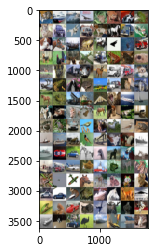

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(valloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

RuntimeError: ignored

In [ ]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# Note: 
## model specs

Total params	23,528,522

Trainable params	23,528,522

Non-trainable params	0

Input size (MB)	7.350000e+01

Forward/backward pass size (MB)	3.667851e+04

Params size (MB)	8.975419e+01

Estimated Total Size (MB)	3.684176e+04




# Reference


https://github.com/sksq96/pytorch-summary#multiple-inputs

https://github.com/berniwal/swin-transformer-pytorch

https://arxiv.org/pdf/2103.14030.pdf